# Navigation

---

By trying out this notebook you will learn how to use [ the Unity ML-Agents environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md) and especially the [Banana Collector](https://youtu.be/heVMs3t9qSk) environment for a project of Udacity's [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)

### 1. Start the Environment

Execute the next cells below to install a few packages like Python and UnityEnvironment. Double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


We also start the environment! Before running the code cell below, change the file_name parameter to match the location of the Unity environment that you downloaded.

- Mac: "path/to/Banana.app"
- Windows (x86): "path/to/Banana_Windows_x86/Banana.exe"
- Windows (x86_64): "path/to/Banana_Windows_x86_64/Banana.exe"
- Linux (x86): "path/to/Banana_Linux/Banana.x86"
- Linux (x86_64): "path/to/Banana_Linux/Banana.x86_64"
- Linux (x86, headless): "path/to/Banana_Linux_NoVis/Banana.x86"
- Linux (x86_64, headless): "path/to/Banana_Linux_NoVis/Banana.x86_64"

For instance, if you are using a Mac, then you downloaded Banana.app. If this file is in the same folder as the notebook, then the line below should appear as follows:

- env = UnityEnvironment(file_name="Banana.app")

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Using this Unity Banana environment, the objective of the project is to design an agent to navigate (and collect bananas!) in a large, square world. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas. The agent’s observation space is 37 dimensional and the agent’s action space is 4 dimensional (forward, backward, turn left, and turn right). The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment. As you can see the agent picks an action randomly ( action = np.random.randint(action_size) ) and this action is passed in the environment's step function. Then next state, reward, done and score is calculated. You should set `train_mode=True` to restart the environment. This project's challenge below is to make the agent to pick better action's after gaining experience over time.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Training the agent!

Here we train the agent to solve the environment!
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
``` 
First of all we import some libraries. We will use [Pytorch](https://pytorch.org/) for defining the Neural Network for this project. Also very important is Numpy amd Matplotlib for plotting the results.

In [6]:
import random
import torch
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

##torch version
print(torch.__version__)

0.4.0


### First we define the Neural Network
This is the most important factor in DQN. I have used 4 Linear layers as part of this network and I have changed the nodes a lot to find the best parameters. I examined a lot the middle layer and saw that when we use larger values than 64 etc 128 or 156 then we solve the environment in fewer episodes. With 128 nodes task is solved in 383 episodes and with 156 is solved in 419.
The Deep Neural Network is used so the agent can approximate the action selection for any state. The input size of the NN is 37 like the state size and the output is 4 like the action size parameter. We use the argmax function so we pick the action with the higher probability.

In [7]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=156, fc3_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)        
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.relu(self.fc4(x))


#### Below we set some hyperparameters
These parameters are very important for the DRL algorithm and slight changes make big impact at training. It apperas that below values contributed to faster training.

#### Also we define the agent class. 
The DQN network will use the "Experience Replay" and the "Fixed Q-Targets" optimizations.

In the constructor we define state size, action size and seed. We initialize 2 identical Neural Networks with the same seed so they get the same weights at the beggining. We use Adam optimizer with very small Learning rate(0.0005). Also we initialize ReplayBuffer which is responsible to store the "experiences" of the agent etc keeps history of different states, actions, rewards, next states and done parameters.

At the step function we save experiences in replay memory and if there are enough experiences in replay buffer then it gives the order to sample some experiences and update the target network with a gamma discount factor to make rewards that are in future less relative than that of current rewards.

At the act function we make a forward pass at the local neural network and we select an action. Now according to the epsilon-greedy-policy we either select the highest scored action, or select randomly among any of the available actions.

At learn function we take use of the SarsaMax algorithm. By this algorithm we tell the agent to pick an action that maximizes reward in the next state based to the specific policy. Then we compute the Q_targets based on reward and gamma factor. We also get Q_expected from local network and after that we compute the loss with Pytorch MSE loss function. We continue the algorithm with making step with the optimizer to correct the weights and at the end we use the soft_update function.

At soft_update function we have a constant TAU. This function updates the target network's weights to match the weights of the local network. Parameter of 1 will result in full synchronization and parameter of 0 will result to NO synchronization

#### Last we have the ReplayBuffer class

This class is resposnible to store the experiences of the agent which include different states, actions, rewards, next states and done parameter. The add method appends the SARS tuple to the memory. The sample method gets random sample of data for the agent with a specific buffer size. The samples are random so that our agent can avoid memorizing sequences and take advantage of experiences that are rare.


In [8]:
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Next we write a function to start training our agent

Here our agent interacts with the environment and takes actions that depend on previous analysed functions. At every episode we:

- Reset the environment
- Follow the epsilon greedy policy
- use agent's step function so to populate the memory with "experiences" and after some steps we trigger the learn function

We continue everything as long the score is above 13 in over 100 episodes. Also a chackpoint is saved after the environment is solved.

Episode 100	Average Score: 1.36
Episode 200	Average Score: 4.98
Episode 300	Average Score: 8.13
Episode 400	Average Score: 10.66
Episode 500	Average Score: 12.78
Episode 519	Average Score: 13.02
Environment solved in 419 episodes!	Average Score: 13.02


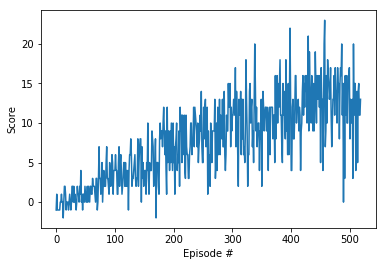

In [9]:
agent = Agent(state_size=37, action_size=4, seed=0)

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):            
            action = agent.act(state, eps).astype(int)       # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) 
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [10]:
env.close()

### Improvements

We can make some improvements to solve the environment to fewer episodes

- Different Batch_Size may result to faster training
- GAMMA factor can be set closer to 1 so that we can make immediate results more effective for our agent when bananas are close enough one to another
- TAU parameter will tweak target network's weight to match those of the local network. Closer to 1 will result in full sync and closer to 0 at NO sync.
- UPDATE_EVERY is a factor that we can change and result to improvements. Here we selected 4 and if we set it to larger numbers will result to improvement of generalization.

We can also use Reinforcement Learning refinements.

- Double DQN - Deal with overestimation of action values.
- Prioritized Experience Replay - To make important experiences more relevant.
- Dueling DQN - Improve performance by dividing a neural network in two streams. One for state values and other for advantage values.
- Rainbow DQN which incorporates all six of below algorithms
 1) Double DQN (DDQN)
 2) Prioritized experience replay
 3) Dueling DQN
 4) Learning from multi-step bootstrap targets
 5) Distributional DQN
 6) Noisy DQN